# Predictions
----
In this notewook, we will build a prediction model.

1. Predict whether a registered user will convert to a renter.
2. Give insights on which features are most predictive on users' conversion.

In [201]:
% matplotlib inline
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# load the data.
data_path = '../source_data/renter_classifier/'
X1 = pd.read_csv(data_path+'X1.csv',index_col=0)
X2 = pd.read_csv(data_path+'X2.csv',index_col=0)
y1 = pd.read_csv(data_path+'y1.csv',index_col=0)
y2 = pd.read_csv(data_path+'y2.csv',index_col=0)

cat_features = ['email_cat','city_cat','age_cat','registered_by_fb']
num_features = ['sign_in_count','info_details','wish_items']

# log the columns that have a long tail
X1['sign_in_count'] = np.log(X1['sign_in_count']+1)
X1['wish_items'] = np.log(X1['wish_items']+1)
#X2['sign_in_count'] = np.log(X2['sign_in_count']+1)
#X2['wish_items'] = np.log(X2['wish_items']+1)

### Predicting 
This is an imbalanced data situation--3% of the useres converting to renters vs. 97% not. Therefore, we need to under-sample the users who do not convert.

In [222]:
def train_renter_classifier(X1,y1,under_sample = 0.04,
                           dummy_features=['email_cat',
                                         'city_cat','age_cat'],
                           drop_features = None):
    """
    Return a trained classifier using under_sampled data.
    dummy_features: features to be transformed to categorical features.
    drop_features: features to be deleted in order to reduce correlation.
    """
    
    # preprocess
    X_dummy = pd.get_dummies(X1,columns=dummy_features)
    if drop_features:
        X_dummy = X_dummy.drop(drop_features,axis=1)
    feature_names = X_dummy.columns

    # down sample the data
    y = y1[~y1.values].sample(frac=under_sample).append(y1[y1.values])
    X = X_dummy.loc[y.index.values,:]
  
    X_train, X_test, y_train, y_test = train_test_split(X, y['Renter'], random_state=0)

    X_train_scale = scale(X_train)
    X_test_scale = scale(X_test)
    
    log = LogisticRegression(penalty='l2',C=1)
    log.fit(X_train_scale,y_train)
    cm = confusion_matrix(y_test,log.predict(X_test_scale))
    
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    return feature_names, log, cm


#### Predict using all features

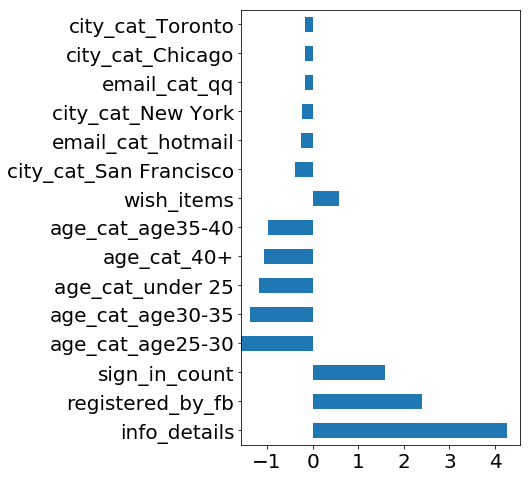

In [227]:
fake_features = ['age_cat_No_age',
                 'city_cat_No address','city_cat_Other City']

cms = [None]*20
coeffs = [None]*20
for i in range(20):
    feature_names, log, cms[i] = train_renter_classifier(X1,y1,drop_features=fake_features)
    coeffs[i] = log.coef_[0]
    
coeffs = pd.DataFrame(coeffs)
coeffs.columns = feature_names
coeffs = coeffs.fillna(0)


# select the top 20 most predictive features
means = pd.DataFrame(coeffs.mean())
means.columns=['coefficient']
means['abs'] = abs(means)
means = means.sort_values(['abs'],ascending=False)
means = means.drop(['abs'],axis=1)
means[0:15].plot(kind='barh',figsize=(5,8),fontsize=20,legend=False)

#### predicting using partial features

In [203]:
drop_features = ['age_cat_No_age','info_details','sign_in_count',
                 'city_cat_No address','city_cat_Other City','wish_items']

cms = [None]*20
coeffs = [None]*20
for i in range(20):
    feature_names, log, cms[i] = train_renter_classifier(X1,y1,drop_features=drop_features)
    coeffs[i] = log.coef_[0]

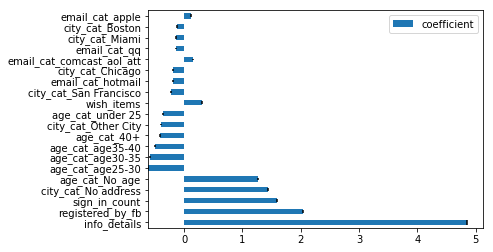

Confusion matrix, without normalization
[[ 0.95496032  0.04503968]
 [ 0.0258216   0.9741784 ]]


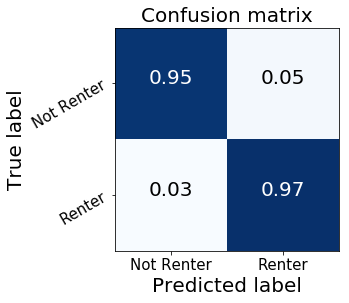

In [224]:
coeffs = pd.DataFrame(coeffs)
coeffs.columns = feature_names
coeffs = coeffs.fillna(0)


# select the top 20 most predictive features
means = pd.DataFrame(coeffs.mean())
means.columns=['coefficient']
means['abs'] = abs(means)
means = means.sort_values(['abs'],ascending=False)
means = means.drop(['abs'],axis=1)
means = means[0:20]

errors = coeffs.std()
errors = errors[means.index]
fig, ax = plt.subplots()
means.plot.barh(yerr=errors, ax=ax)
plt.show()

cm_mean = cms[0]
for i in range(19):
    cm_mean += cms[i+1]
cm_mean = cm_mean/20

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_mean, classes=['Not Renter','Renter'],
                      title='Confusion matrix')

plt.show()

#### Only plot the top 15 featurues

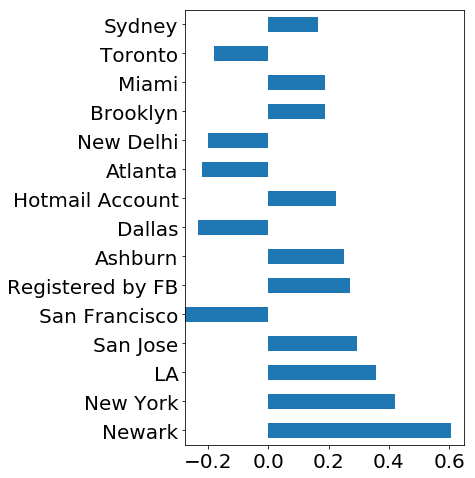

In [205]:
top_means = means[0:15]
top_means.index=['Newark','New York','LA','San Jose','San Francisco',
                  'Registered by FB','Ashburn','Dallas','Hotmail Account','Atlanta',
                   'New Delhi','Brooklyn','Miami','Toronto','Sydney'
                  ]

top_means.plot(kind='barh',figsize=(5,8),fontsize=20,legend=False)


### the average confusion matrix

In [206]:
cm_mean = cms[0]
for i in range(19):
    cm_mean += cms[i+1]

cm_mean = cm_mean/20

Confusion matrix, without normalization
[[ 0.69543651  0.30456349]
 [ 0.43544601  0.56455399]]


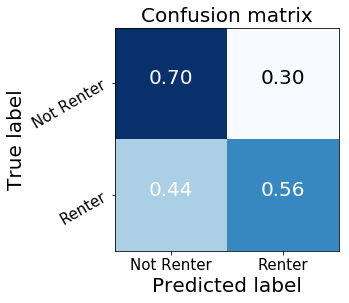

In [220]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
#    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes,rotation=30,fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_mean, classes=['Not Renter','Renter'],
                      title='Confusion matrix')

plt.show()

END